In [1]:
import os
import sys
sys.path.append('../starter_files/')
sys.path.append('../../')
import seaborn as sns

In [2]:
# Built-in modules
import os
import warnings
warnings.filterwarnings('ignore')

import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

In [3]:
from importlib import reload

Background information from starter notebook:


The input images are from _Sentinel-1_, _Sentinel-2_ and _Planet Fusion_, with following details: 

 * _Planet Fusion Surface Reflection_ (PF-SR) imagery contains 4 channels in total: `[blue, green, red, NIR]` channels in order, with 3-meter resolution and the provided data is in `TIFF` imaging format. To elaborate on, the Planet Fusion Monitoring product consists of clean (i.e. free from clouds and shadows), daily gap-filled, high resolution, temporally consistent, radiometrically robust, harmonized and sensor agnostic surface reflectance time series, featuring and synergizing inputs from both public and private sensor sources and directly interoperable with HLS (harmonized Landsat Sentinel) surface reflectance products. The Planet Fusion data is provided in two alternative versions: daily and with a 5-day cadence (a light-weight version composited by applying a median filter to the daily product). Participants have the option to use either. For more details, you can refer to the specifications of [PLANET FUSION]( https://assets.planet.com/docs/Planet_fusion_specification_March_2021.pdf). 

* _Sentinel-1_ (S1) imagery contains 3 channels in total: `[VV, VH, ANGLE]` where _V_ and _H_ stand for vertical and horizontal orientations, respectively, and _ANGLE_ stores the angle of observation to the earth surface as described [here](https://www.nrcan.gc.ca/maps-tools-and-publications/satellite-imagery-and-air-photos/tutorial-fundamentals-remote-sensing/microwave-remote-sensing/radar-image-distortions/9325). The data is collected in Interferometric Wide (IW) swath mode and it includes both ascending and descending orbit directions. For further information about _Sentinel-1_ imagery, please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/). 


* _Sentinel-2_ (S2) includes all L2A bands in the following order `[B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]`. The bands that have original spatial resolution of `20m` and `60m` are interpolated with a nearest-neighbour method to a `10m` resolution. More information about the interpolation process [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#processing-options). Moreover, the cloud probability mask `CLP` is also provided, for more details please refer to [Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data).

## Planet data

https://assets.planet.com/docs/Planet_fusion_specification_March_2021.pdf

Use preprocess_planet.py to generate the time series. In the version here, the standard transform is applied: a random 32 x 32 image is cut from the larger field

Planet fusion data

In [4]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/planet/default/train_data.h5', 'r')
test_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/planet/default/test_data.h5', 'r')

In [5]:
ix = 0
print(train_data.keys())

fid = train_data['fid'][ix] # this is an index that is identifying the agricultural field

print('Feature ID', fid) 

image_stack = train_data['image_stack'][ix] # Planet Fusion bands

print('Image stack shape: TIME x BANDS x WIDTH x HEIGHT', image_stack.shape)

mask = train_data['mask'][ix].astype(bool) # Mask that masks the pixels that belong to the agricultural field
print('Mask shape: WIDTH x HEIGHT', mask.shape)

label = train_data['label'][ix] # finally the crop ID
print('Crop ID (label for supervised learning)', label)

<KeysViewHDF5 ['fid', 'image_stack', 'label', 'mask']>
Feature ID 80172
Image stack shape: TIME x BANDS x WIDTH x HEIGHT (48, 4, 32, 32)
Mask shape: WIDTH x HEIGHT (32, 32)
Crop ID (label for supervised learning) 0


In [6]:
# from starter notebook 

#Define NDVI index for Planet Fusion images
def calc_ndvi(X):
    red = X[2]
    nir = X[3]
    return (nir-red) / (nir + red)
        
#Define True Color for Planet Fusion images
def calc_true_color(X):
    blue = X[0]/(X[0].max()/255.0)
    green = X[1]/(X[1].max()/255.0)
    red = X[2]/(X[2].max()/255.0)
    tc = np.dstack((red,green,blue)) 
    
    return tc.astype('uint8')
        

In [ ]:
ix = 1200

# True color looks strange, maybe an issue with the colormap

image_stack = train_data['image_stack'][ix]
mask = train_data['mask'][ix]
label = train_data['label'][ix]
fid = train_data['fid'][ix]

print(f'Masked pixels: {100 * np.sum(mask) / len(mask.flatten())} %')

print(f'Displaying the field {fid} with crop label {label} throughout growing season')
print('Top row: True color')
print('Bottom row: Normalized vegetation index (NDVI)')

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=[15, 6])

tidxs = range(0, 250, 50)

for i in range(5):
    img = image_stack[tidxs[i]] * mask # Important! Remove the pixels that are masked
    
    true_color = calc_true_color(img)
    ndvi = calc_ndvi(img)
    
    ax[0, i].imshow(true_color)
    ax[1, i].imshow(ndvi, cmap=plt.cm.summer)
    
    ax[0,i].set_title(f'Day {tidxs[i]}')

In [ ]:
labels = train_data['label'][:]

unique_labels, inv, cnt = np.unique(labels, return_inverse=True, return_counts=True)

for u,c in zip(unique_labels, cnt):
    print(f'Crop ID {u}: {c} samples for training')
    

In [ ]:
k = 5

for u in unique_labels:
    sel_ix = np.where(inv==u)[0][:k] # first k fields with this label
    
    for i in sel_ix:
        print(i)
        img = train_data['image_stack'][i]
        m = train_data['mask'][i]
        
        ndvi = [calc_ndvi(X*m) for X in img]
        
        print(np.nanmax(ndvi))
        
        plt.plot(np.nanmean(np.asarray(ndvi), axis=(1, 2)), color='C7')
    
    break

## Planet data (5-day cadence)

Planet fusion data, averaged over 5 days (as provided in the raw data)

In [8]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/planet_5day/default/train_data.h5', 'r')
test_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/planet_5day/default/test_data.h5', 'r')

In [9]:
labels = train_data["label"][:]

NDVI for different crop types. Why are some always negative?

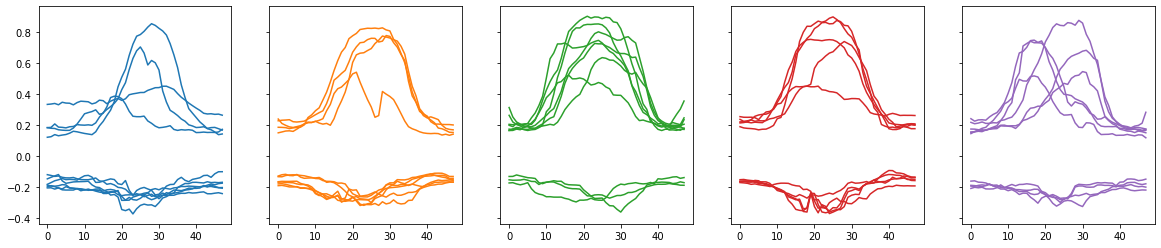

In [10]:
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True, figsize=[20, 4])

for i in range(5):
    ix = np.where(labels==i)[0]    
    
    for k in range(10):
        img = train_data["image_stack"][ix[k]]
        
        ndvi = []
        for j in range(48):
            ndvi.append(np.nanmean(calc_ndvi(img[j])))
            
        ax[i].plot(ndvi, color=f'C{i}')
        

## Sentinel 1 data

https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/

Use preprocess_sentinel_1.py to generate the time series.

Sentinel 1: ascending and descending orbit observations

In [11]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/sentinel-1/default/train_data.h5', 'r')
test_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/sentinel-1/default/test_data.h5', 'r')

In [12]:
print(train_data.keys())

<KeysViewHDF5 ['fid', 'image_stack', 'label', 'mask']>


Look at one sample in detail

In [13]:
idx = 500

In [14]:
image_stack = train_data["image_stack"][idx]
print('Image Stack shape', image_stack.shape) # Dimension: TIME, BAND, IMAGE_SIZE, IMAGE_SIZE

label = train_data["label"][idx]
print('Label', label) # Crop ID

fid = train_data["fid"][idx]
print('FID', fid) # Feature ID (like an index for the agricultural fields)

mask = train_data["mask"][idx].astype(bool)
print('Mask shape', mask.shape) # Dimension: IMAGE_SIZE, IMAGE_SIZE

Image Stack shape (41, 2, 32, 32)
Label 1
FID 81612
Mask shape (32, 32)


In [15]:
labels = train_data["label"][:]
print('All available training+validation samples:', len(labels))

label_ids, label_idcs, label_counts = np.unique(labels, return_counts=True, return_inverse=True)

for ll, cc in zip(label_ids, label_counts):
    print(f'Crop ID with label {ll}: {cc} counts')

All available training+validation samples: 4143
Crop ID with label 0: 1788 counts
Crop ID with label 1: 660 counts
Crop ID with label 2: 510 counts
Crop ID with label 3: 751 counts
Crop ID with label 4: 434 counts


Plot a single field over time

In [16]:
# DEFINE RADAR VEGETATION INDEXING FOR VISUALISATION OF  S1 DATA: 
# for the algorithm please refer to Sentinel Hub: 
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/radar_vegetation_index_code_dual_polarimetric/

def calc_rvi(X, mask=None):
    VV = X[0]
    VH = X[1]
    
    if mask is not None:
        VV[~mask] = None
        VH[~mask] = None
    
    dop = (VV/(VV+VH))
    m = 1 - dop
    radar_vegetation_index = (np.sqrt(dop))*((4*(VH))/(VV+VH))
    
    return radar_vegetation_index

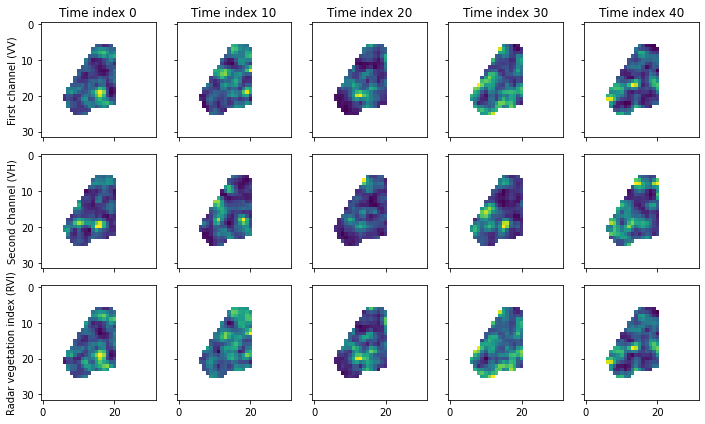

In [17]:
time_idx = [0, 10, 20, 30, 40]

fig, axs = plt.subplots(3, len(time_idx), sharex=True, sharey=True, figsize=[10, 6])

for i, tidx in enumerate(time_idx):
    # first band: VV ()
    VV = image_stack[tidx][0]
    # just for the display set masked pixels to None
    VV[~mask] = None
    axs[0, i].imshow(VV)
    
    VH = image_stack[tidx][1]
    # just for the display set masked pixels to None
    VH[~mask] = None
    axs[1, i].imshow(VH)
    
    rvi = calc_rvi(image_stack[tidx], mask=mask) 
    axs[2, i].imshow(rvi)
    
    axs[0,i].set_title(f'Time index {tidx}')
    
axs[0,0].set_ylabel('First channel (VV)')
axs[1,0].set_ylabel('Second channel (VH)')
axs[2,0].set_ylabel('Radar vegetation index (RVI)')

fig.tight_layout()

Plot Radar Vegetation Index for various fields

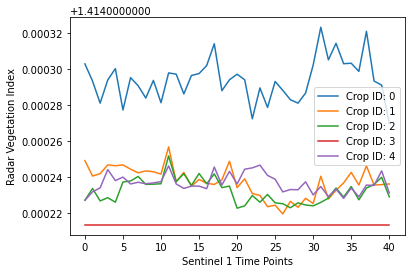

In [18]:
for i in label_ids:
    ix = np.where(label_idcs==i)[0][10] # first image with that label
    image_stack = train_data["image_stack"][ix]
    label = train_data["label"][ix]
    rvi = np.nanmean([calc_rvi(X, mask=mask) for X in image_stack], axis=(1,2))
    plt.plot(rvi, label=f'Crop ID: {label}')
    
plt.legend()
plt.xlabel('Sentinel 1 Time Points')
plt.ylabel('Radar Vegetation Index')

plt.show()

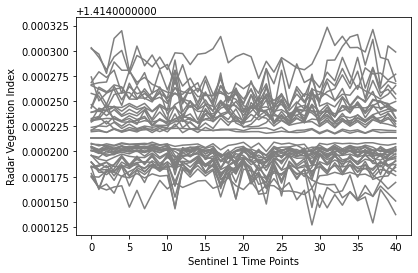

In [19]:
# the RVI for various fields with the same crop id label
for i in range(50):
    ix = np.where(label_idcs==0)[0][i] 
    image_stack = train_data["image_stack"][ix]
    label = train_data["label"][ix]
    rvi = np.nanmean([calc_rvi(X, mask=mask) for X in image_stack], axis=(1,2))
    plt.plot(rvi, label=f'Crop ID: {label}', color='C7')
    
plt.xlabel('Sentinel 1 Time Points')
plt.ylabel('Radar Vegetation Index')

plt.show()

## Sentinel 2 data

In [20]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/sentinel-2/default/train_data.h5', 'r')

In [21]:
print(train_data.keys())

<KeysViewHDF5 ['fid', 'image_stack', 'label', 'mask']>


Look at one sample in detail

In [22]:
idx = 49

In [23]:
image_stack = train_data["image_stack"][idx]
print('Image Stack shape', image_stack.shape) # Dimension: TIME, BAND, IMAGE_SIZE, IMAGE_SIZE

label = train_data["label"][idx]
print('Label', label) # Crop ID

fid = train_data["fid"][idx]
print('FID', fid) # Feature ID (like an index for the agricultural fields)

mask = train_data["mask"][idx].astype(bool)
print('Mask shape', mask.shape) # Dimension: IMAGE_SIZE, IMAGE_SIZE

Image Stack shape (76, 12, 32, 32)
Label 2
FID 80232
Mask shape (32, 32)


In [24]:
def calc_ndvi_sentinel2(X):
    nir = X[7]
    red = X[3]
    
    ndvi = (nir - red) / (nir + red)    
    return ndvi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


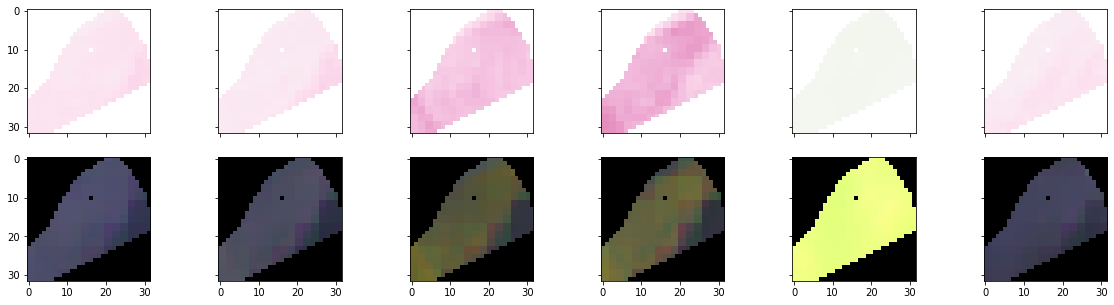

In [28]:
fig, ax = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(20, 5))

tidxs = np.arange(0, 76, 15)

for i in range(6):
    img = image_stack[tidxs[i]]
        
    ndvi = calc_ndvi_sentinel2(img)
    
    true_color = img[[3,2,1]].swapaxes(0, 1).swapaxes(1, 2)
    
    ndvi[~mask] = None
    true_color[~mask] = None
    
    ax[0, i].imshow(ndvi, vmin=-1, vmax=+1, cmap='PiYG')
    ax[1, i].imshow(true_color)

In [26]:
ndvi = [np.nanmean(calc_ndvi_sentinel2(X)) for X in image_stack]

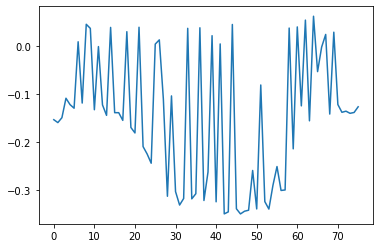

In [27]:
plt.plot(ndvi)